In [5]:
import sys
sys.path.append('../')

import numpy as np
import healpy as hp

from simulations.wrapper import simulator
from utils import create_mask as cm
from utils.psf import KingPSF

In [21]:
data_dir = "../data/fermi_data_573w/fermi_data_128/"

def simulate(theta, dnds_list, s_ary, r_outer=180, nside=128, dif="ModelO"):
    """High-level simulation script"""

    # Get mask of central pixel for nside=1
    hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask=True, band_mask_range=0, mask_ring=True, inner=0, outer=r_outer)

    # Get mask corresponding to nside=128
    mask_sim = hp.ud_grade(hp_mask_nside1, nside)

    # ROI to normalize counts over
    mask_normalize_counts = cm.make_mask_total(nside=nside, band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=25.0)

    mask_roi = cm.make_mask_total(nside=nside, band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=r_outer)

    # King PSF hard-coded for now
    kp = KingPSF()

    # Load standard templates
    temp_gce = np.load("{}/template_nfw_g1p2.npy".format(data_dir))
    temp_dif = np.load("{}/template_dif.npy".format(data_dir))
    temp_psc = np.load("{}/template_psc_3fgl.npy".format(data_dir))
    temp_iso = np.load("{}/template_iso.npy".format(data_dir))
    temp_dsk = np.load("{}/template_dsk_z0p3.npy".format(data_dir))
    temp_bub = np.load("{}/template_bub.npy".format(data_dir))

    # Load exposure
    fermi_exp = np.load("{}/fermidata_exposure.npy".format(data_dir))

    # Rescaling factor to remove exposure from PS templates
    rescale = fermi_exp / np.mean(fermi_exp)

    # Load Model O templates
    temp_mO_pibrem = np.load("{}/template_Opi.npy".format(data_dir))
    temp_mO_ics = np.load("{}/template_Oic.npy".format(data_dir))

    # Load Model A templates
    temp_mA_pibrem = hp.ud_grade(np.load("{}/template_Api.npy".format(data_dir)), nside_out=128, power=-2)
    temp_mA_ics = hp.ud_grade(np.load("{}/template_Aic.npy".format(data_dir)), nside_out=128, power=-2)

    # Load Model F templates
    temp_mF_pibrem = hp.ud_grade(np.load("{}/template_Fpi.npy".format(data_dir)), nside_out=128, power=-2)
    temp_mF_ics = hp.ud_grade(np.load("{}/template_Fic.npy".format(data_dir)), nside_out=128, power=-2)

    # List of templates except GCE template
    temps_ps = [temp_dsk / rescale]

    if dif == "ModelO":
        temps_poiss = [temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
    elif dif == "ModelA":
        temps_poiss = [temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]
    elif dif == "ModelF":
        temps_poiss = [temp_iso, temp_bub, temp_psc, temp_mF_pibrem, temp_mF_ics]
    elif dif == "p6v11":
        temps_poiss = [temp_iso, temp_bub, temp_psc, temp_dif]
    else:
        raise NotImplementedError


    x, aux = simulator(theta, dnds_list, s_ary, [temp_gce] + temps_poiss, [temp_gce / rescale] + temps_ps, mask_sim, mask_normalize_counts, mask_roi, kp.psf_fermi_r, fermi_exp)

    return x, aux

In [22]:
def dnds(s, theta):
    """ BPL SCD dN/dS with 3 breaks
    """
    a, n1, n2, n3, sb1, sb2 = theta
    dnds = a * (sb2 / sb1) ** -n2 * np.where(s < sb2, (s / sb2) ** (-n3), np.where((s >= sb2) * (s < sb1), (s / sb2) ** (-n2), (sb1 / sb2) ** (-n2) * (s / sb1) ** (-n1)))
    return dnds

# Norms of components
# dm (pois), iso, bub, psc, dif_pibrem, dif_ics, gce (ps), disk (ps)
# dm (pois), gce (ps), disk (ps) are speficied as counts/pix in ROI, others are raw template norms
theta = np.array([0.2, 0.001, 0.001, 0.001, 2.0, 1.0, 5., 0.])

s_ary = np.logspace(-1, 2, 100)

# Get SCDs for the 2 populations
dnds_gce = dnds(s_ary, [1., 10., -1.5, -10., 20., 1.])
dnds_dsk = dnds(s_ary, [1., 10., -1.5, -10., 20., 1.])
dnds_list = [dnds_gce, dnds_dsk]

# Simulate
x, _ = simulate(theta=theta, s_ary=s_ary, dnds_list=dnds_list)

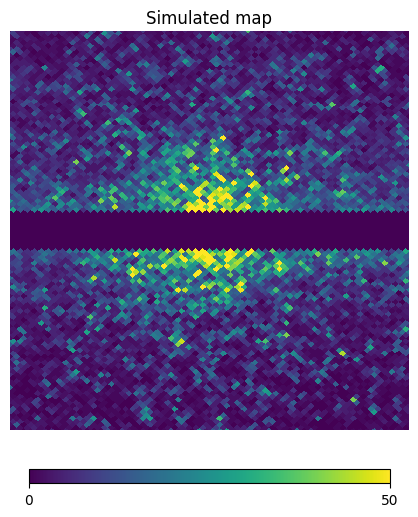

In [68]:
hp.cartview(x[0], lonra=[-20, 20], latra=[-20, 20], title="Simulated map", cmap="viridis", min=0., max=50)